In [45]:
%load_ext autoreload
%autoreload 2

import os
import hydromt
from hydromt_summa.summa import SummaModel
from hydromt import workflows, flw
import xarray as xr
from hydromt.log import setuplog
import numpy as np
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_catalogue_path = os.path.join(os.path.expanduser("~"),'projects','rpp-kshook','CompHydCore','datacatalog.yml')
logger = setuplog('test_datacat', log_level=10)
data_catalog = hydromt.DataCatalog(data_catalogue_path, logger=logger)

2022-09-13 17:29:39,331 - test_datacat - log - INFO - HydroMT version: 0.5.1.dev
2022-09-13 17:29:39,334 - test_datacat - data_catalog - INFO - Parsing data catalog from /home/ayx374/projects/rpp-kshook/CompHydCore/datacatalog.yml


In [4]:
root = os.path.join('./summa_bowatbanff_discretization')
mod = SummaModel(root=root, mode="w",
                  data_libs=[data_catalogue_path])
bbox = [-116.55,50.95,-115.52,51.74]
_region = {'subbasin': [[-115.53],[50.964]], 'uparea': 2000, 'bounds': bbox}
r = mod.setup_region(_region)

<AxesSubplot:>

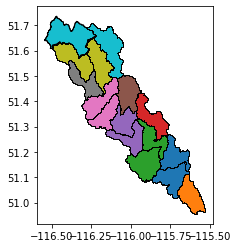

In [6]:
ds = mod.data_catalog.get_rasterdataset("merit_hydro", geom = mod.region)
ruds = workflows.hydrography_to_basins(
    ds,
    mod.region,
    "us_area",
    area_min=100,
)
subbasins_gpd = workflows.ru_geometry_to_gpd(ruds)
subbasins_gpd.plot(column='value',edgecolor='black',categorical=True)

In [134]:
soilclass_fn = 'usda_soilclass'
landclass_fn = 'modis_landclass_vrt4326'
ds_soil = mod.data_catalog.get_rasterdataset(soilclass_fn,geom=mod.region,buffer=2)

ds_land = mod.data_catalog.get_rasterdataset(landclass_fn,geom=mod.region,buffer=2)
ds_land_stack = ds_land.to_stacked_array(new_dim='years',sample_dims=['x','y'])
# calculate mode across years dimension, stored in np.array
modestat = stats.mode(ds_land_stack,axis=2,nan_policy='omit')[0].squeeze().astype('float')
# create data array from np.array
ds_landclass_mode = xr.DataArray(modestat,{'y':ds_land.y,'x': ds_land.x})
ds_landclass_mode = ds_landclass_mode.to_dataset(name='landclass')

ds_landclass_mode = ds_landclass_mode.rio.write_crs(ds_land.rio.crs)
ds_landclass_mode = ds_landclass_mode.assign_attrs({'_FillValue':0.0})

In [135]:
ds_soil.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(1)
Coordinates:
    spatial_ref  int64 1
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -180.0 0.0020833330000009018 0.0 83.9991672...
    x_dim:                        x
    y_dim:                        y

In [136]:
ds_landclass_mode.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...

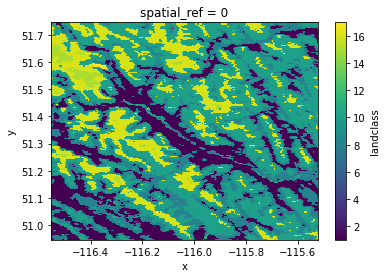

In [137]:
ds_landclass_mode.landclass.plot()

In [138]:
# which has the highest resolution?
# find out by comparing x and y
def ds_resolution(ds, x='x',y='y'):
    xres = abs(ds_land[x].values[1]-ds_land[x].values[0])
    yres = abs(ds_land[y].values[1]-ds_land[y].values[0])
    return xres,yres

def compare_resolutions(ds_list):
    reslist = []
    for ds in ds_list:
        reslist.append( max(ds_resolution(ds)) )
    return np.argmax(reslist)

In [139]:
xres, yres = ds_resolution(ds_soil)

In [140]:
max(ds_resolution(ds_soil))

0.0041666666662862895

In [141]:
ds_list = [ds_soil,ds_landclass_mode]
highestres_loc = compare_resolutions(ds_list)
highestres = ds_list[highestres_loc]
other_ds = [ds for i,ds in enumerate(ds_list) if i!=highestres_loc] 

In [142]:
ds_landclass_mode.raster.reproject_like(ds_soil)

<xarray.Dataset>
Dimensions:      (y: 378, x: 491)
Coordinates:
  * y            (y) float64 51.74 51.74 51.73 51.73 ... 50.96 50.96 50.95 50.95
  * x            (x) float64 -116.5 -116.5 -116.5 ... -115.5 -115.5 -115.5
    spatial_ref  int64 0
Data variables:
    landclass    (y, x) float64 9.0 9.0 9.0 11.0 11.0 ... 10.0 10.0 16.0 16.0
Attributes:
    _FillValue:  0.0

In [143]:
reprojected_ds_list = []
for ds in other_ds:
    reprojected_ds_list.append( ds.raster.reproject_like(highestres) )

In [144]:
ds_classes = xr.merge([highestres]+reprojected_ds_list,compat='override') # override due to spatial ref not reassigned

In [145]:
ds_classes

<xarray.Dataset>
Dimensions:      (x: 491, y: 378)
Coordinates:
  * x            (x) float64 -116.5 -116.5 -116.5 ... -115.5 -115.5 -115.5
  * y            (y) float64 51.74 51.74 51.73 51.73 ... 50.96 50.96 50.95 50.95
    spatial_ref  int64 1
    mask         (y, x) bool False False False False ... False False False False
Data variables:
    tax_usda     (y, x) float32 dask.array<chunksize=(378, 491), meta=np.ndarray>
    landclass    (y, x) float64 9.0 9.0 9.0 11.0 11.0 ... 10.0 10.0 16.0 16.0
Attributes:
    _FillValue:      0.0
    source_file:     usda_mode_soilclass_250m_ll.tif
    category:        soil
    notes:           Soilgrids data preprocessed into classes by Wouter Knoben
    paper_doi:       10.4211/hs.1361509511e44adfba814f6950c6e742
    paper_ref:       Knoben, W. J. M. (2021)
    source_license:  ODbL
    source_url:      https://www.isric.org/explore/soilgrids/faq-soilgrids-2017
    source_version:  2017

In [151]:
comb = np.char.add( ds_classes['tax_usda'].values.astype('int').astype('str') , ds_classes['tax_usda'].values.astype('int').astype('str') )

In [194]:
def combine_classes(ds):
    classvars = list(ds_classes)
    for i, v in enumerate(classvars):
        # convert raster value to str, and format str to the same length (i.e., the max str length) 
        raster_value = ds[v]
        raster_mask = ds[v].mask
        raster_str = raster_value.astype(str)
        max_len    = max(map(len,raster_str))
        #raster_str_max_len_list.append(max_len)
        raster_str_fmt = np.char.zfill(raster_str,max_len)
        
        if i == 0:
            hru_str_fmt = raster_str_fmt
            hru_mask    = (raster_mask!=0)
        else:
            hru_str_fmt = np.char.add(hru_str_fmt, raster_str_fmt)
            hru_mask = (hru_mask & raster_mask)
        return hru_str_fmt, hru_mask

In [195]:
hru_str_fmt, hru_mask = combine_classes(ds_classes)

In [196]:
# assign the unique integer to unique HRU (HRU_str_fmt)
# note: the defined numpy array dtype needs to be consistent with the available rasterio dytpes (e.g., int32,float32,float64).
# note: rasterio dytpes doesn't have int64.
hru_int = np.zeros(np.shape(hru_str_fmt), dtype=np.int32)
unique_hrus_str = np.unique(hru_str_fmt[hru_mask!=0]) 
for ihru, hru in enumerate(unique_hrus_str):
    hru_mask = hru_str_fmt == hru
    hru_int[hru_mask] = int(ihru)+1
hru_int_ma = np.ma.masked_array(hru_int,hru_mask==0)

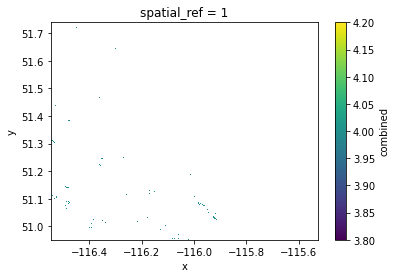

In [202]:
ds_classes['combined'] = (['y','x'],hru_int_ma)
ds_classes['combined'].plot()

In [158]:
v='tax_usda'

In [180]:
raster_value = ds_classes[v]
raster_str = raster_value.astype(str)
max_len    = max(map(len,raster_str))
#raster_str_max_len_list.append(max_len)
raster_str_fmt = np.char.zfill(raster_str,max_len)

In [179]:
raster_str_fmt

array([['8.0', '3.0', '8.0', ..., '3.0', '3.0', '3.0'],
       ['8.0', '3.0', '3.0', ..., '3.0', '3.0', '3.0'],
       ['3.0', '8.0', '3.0', ..., '3.0', '3.0', '3.0'],
       ...,
       ['3.0', '3.0', '3.0', ..., '3.0', '3.0', '3.0'],
       ['3.0', '3.0', '0.0', ..., '3.0', '3.0', '3.0'],
       ['3.0', '3.0', '0.0', ..., '3.0', '3.0', '3.0']], dtype='<U3')